<a href="https://colab.research.google.com/github/IonaSantana/Artificial-Intelligence/blob/main/Projects/NLP/Maiores_investimentos_licitac%CC%A7o%CC%83es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Situação:

Usando os dados das licitações do ano de 2021, no Rio Grande do Sul, fazer uma análise dos principais itens licitados e das áreas que receberam maior investimento por meio de licitações

Link: http://dados.tce.rs.gov.br/dataset?groups=licitacoes&q=consolidado

Referências:

https://github.com/PatrickLdA/licitacoes-RS/blob/main/notebook.ipynb

https://medium.com/somos-tera/como-modelar-t%C3%B3picos-atrav%C3%A9s-de-latent-dirichlet-allocation-lda-atrav%C3%A9s-da-biblioteca-gensim-1fa17357ad4b

### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
#
import spacy 
import nltk

In [2]:
# Libs adicionais de NLP
import spacy 
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re

In [3]:
from sklearn.decomposition import LatentDirichletAllocation

#gráficos 
import pyLDAvis
import pyLDAvis.gensim_models

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.ldamulticore import LdaMulticore
from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [5]:
import matplotlib.colors as mcolors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
files = os.listdir('/content/drive/MyDrive/NLP/2021')

In [8]:
files

['pessoas.csv',
 'membrocons.csv',
 'comissao.csv',
 'memcomissao.csv',
 'licitacao.csv',
 'licitante.csv',
 'dotacao_lic.csv',
 'evento_lic.csv',
 'documento_lic.csv',
 'lote.csv',
 'item.csv',
 'proposta.csv',
 'lote_prop.csv',
 'item_prop.csv']

In [9]:
licitacao = pd.read_csv('/content/drive/MyDrive/NLP/2021/' + files[4])
item = pd.read_csv('/content/drive/MyDrive/NLP/2021/' + files[10])

### Pré-processamento Dados

In [10]:
cols = ['CD_ORGAO', 'NM_ORGAO', 'NR_LICITACAO', 'CD_TIPO_MODALIDADE','DS_OBJETO', 'VL_LICITACAO', 'BL_COVID19']
licitacao_21 = licitacao[cols]

In [11]:
licitacao_21 = licitacao_21.dropna()

In [12]:
licitacao_21.head(3)

,CD_ORGAO,NM_ORGAO,NR_LICITACAO,CD_TIPO_MODALIDADE,DS_OBJETO,VL_LICITACAO,BL_COVID19
0,53100,PM DE NOVA PALMA,1.0,TMP,CONTRATAÇÃO GLOBAL DE EMPRESA PARA CONSTRUÇÃO ...,259765.0,N
1,86800,PM DE BOA VISTA DO SUL,2.0,PRP,Contratação de empresa para prestação de servi...,390625.0,N
2,45003,SERVIÇO AUTÔN. MUN. DE ÁGUA E ESGOTO - CX.SUL,46.0,PRP,Aquisição de 80.000 (oitenta mil) quilogramas ...,833800.0,N


In [13]:
item_licitacao = item.iloc[:, 0:12]
item_licitacao['BL_COVID19'] = item['BL_COVID19'] 

In [14]:
item_licitacao.isna().sum()

CD_ORGAO                    0
NR_LICITACAO                0
ANO_LICITACAO               0
CD_TIPO_MODALIDADE          0
NR_LOTE                     0
NR_ITEM                     0
NR_ITEM_ORIGINAL            0
DS_ITEM                     1
QT_ITENS                    0
SG_UNIDADE_MEDIDA           0
VL_UNITARIO_ESTIMADO    39446
VL_TOTAL_ESTIMADO       39446
BL_COVID19                  0
dtype: int64

In [15]:
item_licitacao = item_licitacao.dropna()

In [16]:
len(licitacao_21), len(item_licitacao)

(87469, 932800)

In [17]:
licitacao_21['covid'] = np.where((licitacao_21['BL_COVID19'] == 'S'), ' covid19', '')
licitacao_21['DS_OBJETO'] = licitacao_21['DS_OBJETO'] + licitacao_21['covid']

In [18]:
licitacao_21 = licitacao_21.drop(['BL_COVID19', 'covid'], axis = 1)

In [19]:
item_licitacao['covid'] = np.where((item_licitacao['BL_COVID19'] == 'S'), ' covid19', '')
item_licitacao['DS_ITEM'] = item_licitacao['DS_ITEM'] + item_licitacao['covid']

In [20]:
item_licitacao = item_licitacao.drop(['BL_COVID19', 'covid'], axis = 1)

In [21]:
item_licitacao['ANO_LICITACAO'].unique()
item_licitacao.drop(['ANO_LICITACAO'], axis = 1).head(3)

,CD_ORGAO,NR_LICITACAO,CD_TIPO_MODALIDADE,NR_LOTE,NR_ITEM,NR_ITEM_ORIGINAL,DS_ITEM,QT_ITENS,SG_UNIDADE_MEDIDA,VL_UNITARIO_ESTIMADO,VL_TOTAL_ESTIMADO
0,44500,274.0,CPC,1,1,1,Credenciamento de academias de ginástica e mus...,1.0,UN,50.00,50.00
1,56900,25.0,TMP,1,1,1.1,PLACA DE OBRA (PARA CONSTRUCAO CIVIL) EM CHAPA...,6.0,M2,272.49,1634.94
2,56900,25.0,TMP,1,2,1.2,TAPUME COM COMPENSADO DE MADEIRA. AF_05/2018,71.0,M2,128.69,9136.99


### Pré-processamento Texto

In [7]:
nlp=spacy.load("pt_core_news_sm")
nltk.download('stopwords')

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
stopwords = nltk.corpus.stopwords.words('portuguese')

filter_out = stopwords + ['kg', 'm', 'cm', 'mm', 'mg', 'ml', 'm²', '-', '+', '=', 'mcg', 'nº', 'g', 'ª', 'º', '_']

In [9]:
filter_out = filter_out + ['cor', 'cores', 'un', 'branco', 'unidades', 
'litros', 'af', 'mgml', 'nbr', 'dn', 'eou', 'referência', 'conforme',
'demais', 'deverá', 'tipo', 'r', 'gb', 'km']

In [10]:
filter_out = filter_out + ['ca', 'cx', 'ser', 'novo', 'ano', 'gr', 'deve', 'data', 'contar', 'resistente', 'partir', 'in', 'boa', 'limpa', 'qualidade', 'tamanho', 'apresentar', 'estar']

Para o pré-processamento do texto foi usado linguagem regular, a tabela abaixo contém algumas informações utéis para entender a função de pre_processing

<table ><tr><th>Character</th><th>Description</th><th>Example Pattern Code</th><th >Exammple Match</th></tr>

<tr ><td><span >\d</span></td><td>A digit</td><td>file_\d\d</td><td>file_25</td></tr>

<tr ><td><span >\w</span></td><td>Alphanumeric</td><td>\w-\w\w\w</td><td>A-b_1</td></tr>



<tr ><td><span >\s</span></td><td>White space</td><td>a\sb\sc</td><td>a b c</td></tr>



<tr ><td><span >\D</span></td><td>A non digit</td><td>\D\D\D</td><td>ABC</td></tr>

<tr ><td><span >\W</span></td><td>Non-alphanumeric</td><td>\W\W\W\W\W</td><td>*-+=)</td></tr>

<tr ><td><span >\S</span></td><td>Non-whitespace</td><td>\S\S\S\S</td><td>Yoyo</td></tr></table>
<table ><tr><th>Character</th><th>Description</th><th>Example Pattern Code</th><th >Exammple Match</th></tr>
</br>
<tr ><td><span >+</span></td><td>Occurs one or more times</td><td>	Version \w-\w+</td><td>Version A-b1_1</td></tr>

<tr ><td><span >{3}</span></td><td>Occurs exactly 3 times</td><td>\D{3}</td><td>abc</td></tr>



<tr ><td><span >{2,4}</span></td><td>Occurs 2 to 4 times</td><td>\d{2,4}</td><td>123</td></tr>



<tr ><td><span >{3,}</span></td><td>Occurs 3 or more</td><td>\w{3,}</td><td>anycharacters</td></tr>

<tr ><td><span >\*</span></td><td>Occurs zero or more times</td><td>A\*B\*C*</td><td>AAACC</td></tr>

<tr ><td><span >?</span></td><td>Once or none</td><td>plurals?</td><td>plural</td></tr></table>

In [26]:
def pre_processing(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r"[^\w\s]", "", sentence)
    sentence = re.sub(r"[0-9]+", "", sentence)
    sentence = re.sub(r"/+", "", sentence)
    sentence = re.sub(r" {2,}", " ", sentence)

    #Tokenização
    doc = nlp(sentence)

    tokens=[token.text for token in doc]
    tokens=[token for token in tokens if token not in filter_out]

    return tokens


In [27]:
print(pre_processing('testando 1 2 3 aa'))

['testando', 'aa']


In [28]:
item_licitacao['DS_ITEM_TOKEN'] = item_licitacao['DS_ITEM'].apply(lambda sentece: pre_processing(sentece))


In [ ]:
item_licitacao.to_csv('item_licitacao_token.csv')

In [30]:
licitacao_21['DS_OBJETO_TOKEN'] = licitacao_21['DS_OBJETO'].apply(lambda sentece: pre_processing(sentece))


In [31]:
licitacao_21.to_csv('licitacao_21_token.csv')

### Construção dos modelos

Counter Vectorizarion -> contar a ocorrência de cada palavra para mapear o texto para um número

CounterVectorizer

TfidfVectorizer -> cria a mais uma matriz de termos de documento a partir de nossas mensagens.
No entanto, em vez de preencher o DTM com contagens de token, ele calcula o valor da frequência do documento inverso da frequência do termo para cada palavra (TF-IDF).
Um fator de frequência de documento inverso é incorporado, o que diminui o peso dos termos que ocorrem com muita frequência no conjunto de documentos e aumenta o peso dos termos que ocorrem raramente.


In [32]:
licitacao_21.head(3)

,CD_ORGAO,NM_ORGAO,NR_LICITACAO,CD_TIPO_MODALIDADE,DS_OBJETO,VL_LICITACAO,DS_OBJETO_TOKEN
0,53100,PM DE NOVA PALMA,1.0,TMP,CONTRATAÇÃO GLOBAL DE EMPRESA PARA CONSTRUÇÃO ...,259765.0,"[contratação, global, empresa, construção, par..."
1,86800,PM DE BOA VISTA DO SUL,2.0,PRP,Contratação de empresa para prestação de servi...,390625.0,"[contratação, empresa, prestação, serviços, tr..."
2,45003,SERVIÇO AUTÔN. MUN. DE ÁGUA E ESGOTO - CX.SUL,46.0,PRP,Aquisição de 80.000 (oitenta mil) quilogramas ...,833800.0,"[aquisição, oitenta, mil, quilogramas, ortopol..."


In [33]:
item_licitacao.head(3)

,CD_ORGAO,NR_LICITACAO,ANO_LICITACAO,CD_TIPO_MODALIDADE,NR_LOTE,NR_ITEM,NR_ITEM_ORIGINAL,DS_ITEM,QT_ITENS,SG_UNIDADE_MEDIDA,VL_UNITARIO_ESTIMADO,VL_TOTAL_ESTIMADO,DS_ITEM_TOKEN
0,44500,274.0,2021,CPC,1,1,1,Credenciamento de academias de ginástica e mus...,1.0,UN,50.00,50.00,"[credenciamento, academias, ginástica, muscula..."
1,56900,25.0,2021,TMP,1,1,1.1,PLACA DE OBRA (PARA CONSTRUCAO CIVIL) EM CHAPA...,6.0,M2,272.49,1634.94,"[placa, obra, construcao, civil, chapa, galvan..."
2,56900,25.0,2021,TMP,1,2,1.2,TAPUME COM COMPENSADO DE MADEIRA. AF_05/2018,71.0,M2,128.69,9136.99,"[tapume, compensado, madeira]"


In [11]:
licitacao_21 = pd.read_csv('/content/drive/MyDrive/NLP/licitacao_21_token.csv')
item_licitacao = pd.read_csv('/content/drive/MyDrive/NLP/item_licitacao_token.csv')

In [14]:
item_licitacao.columns

Index(['Unnamed: 0', 'CD_ORGAO', 'NR_LICITACAO', 'ANO_LICITACAO',
       'CD_TIPO_MODALIDADE', 'NR_LOTE', 'NR_ITEM', 'NR_ITEM_ORIGINAL',
       'DS_ITEM', 'QT_ITENS', 'SG_UNIDADE_MEDIDA', 'VL_UNITARIO_ESTIMADO',
       'VL_TOTAL_ESTIMADO', 'DS_ITEM_TOKEN'],
      dtype='object')

In [12]:
lic= [d.split() for d in item_licitacao['DS_ITEM_TOKEN']]


In [13]:
id2word = corpora.Dictionary(lic)

In [14]:
texts = item_licitacao['DS_ITEM_TOKEN']

Após o treinamento algumas vezes, foi notado outras stopwords.

In [15]:
corpus = [id2word.doc2bow(text.split()) for text in texts]

# Visualização
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 3), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]]


In [16]:
# Corpus num formado simplificado (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[("'academias',", 1),
  ("'cada',", 1),
  ("'canoas',", 1),
  ("'credenciado',", 1),
  ("'desembolsado',", 1),
  ("'escolhido',", 1),
  ("'estabelecimento',", 2),
  ("'exercícios',", 1),
  ("'físicos',", 1),
  ("'ginástica',", 1),
  ("'matriculado',", 1),
  ("'ministrem',", 1),
  ("'município',", 3),
  ("'musculação',", 1),
  ("'outro',", 1),
  ("'servidor',", 1),
  ("'servidor']", 1),
  ("'valor',", 1),
  ("'âmbito',", 1),
  ("['credenciamento',", 1)]]

## **LDA + CountVectorizer**

In [17]:
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words=filter_out)

Função de coerência

In [31]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=id2word, num_topics = num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=lic, limit=20, start=1, step=3)

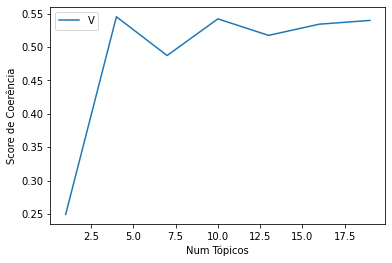

In [33]:
limit=20; start=1; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()

In [34]:
for m, c in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(c, 4))

A quantidade de tópicos = 1  tem um valor de coerência de  0.2493
A quantidade de tópicos = 4  tem um valor de coerência de  0.5452
A quantidade de tópicos = 7  tem um valor de coerência de  0.4871
A quantidade de tópicos = 10  tem um valor de coerência de  0.542
A quantidade de tópicos = 13  tem um valor de coerência de  0.5173
A quantidade de tópicos = 16  tem um valor de coerência de  0.534
A quantidade de tópicos = 19  tem um valor de coerência de  0.5397


A quantida de tópicos a ser usada é 4: por ser o maior encontrado dentre os 20

In [ ]:
lda_model = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=4, 
                        workers = 3,
                        random_state=100,
                        per_word_topics=True)

Salvar modelos

In [36]:
lda_model.save('multicore_4topics')

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Carregar Modelos

In [37]:
from gensim.test.utils import datapath

In [39]:
lda_model = LdaMulticore.load(datapath("/content/multicore_4topics")) 

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [40]:
#função Score de Coerência
def score_coherence (lda_model,lic,id2word):
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lic, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nScore de Coerência: ', coherence_lda)

In [41]:
score_coherence(lda_model,lic,id2word)


Score de Coerência:  0.4947083265662168


In [42]:
pyLDAvis.enable_notebook()

In [44]:
display_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

In [45]:
pyLDAvis.display(display_data)  

Salvar tópicos

In [41]:
def topic_prediction(corpus, lda_model):
    string_input = [corpus]
    X = string_input

    # Convert sparse matrix to gensim corpus.
    output = list(lda_model[corpus])[0]
    topics = sorted(output,key=lambda x:x[1],reverse=True)
    return topics[0][0]

In [47]:
topics = []
for corp in tqdm(corpus):
    topics.append(topic_prediction(corp, lda_model))

item_licitacao['topic_lda'] = topics
item_licitacao.to_csv('item_modeled_5_topics.csv')

100%|██████████| 932800/932800 [15:19<00:00, 1014.29it/s]


Qual a diferença entre LDA e NMF?


Desvendando o latent Dirichlet Allocation - https://web.icmc.usp.br

O objetivo é esclarecer essa relação em termos de formulação matemática, demonstrando que o NMF com divergência KL aproxima a solução obtida pelo algoritmo de inferência variacional do LDA.

As correspondências entre NMF com divergência KL e o algoritmo de inferência variacional para o LDA seguem do fato de que ambos tentam minimizar a divergência entre as estatísticas que relacionam a frequência de palavras, documentos por tópicos e tópicos por palavras. 



### NMF + TfidfVectorizer

Foi notado a permanência de pontuações, por isso será adota o TfidfVectorizer

In [21]:
#!python -m pip install -U gensim
from gensim.models.nmf import Nmf as GensimNmf
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

In [22]:
corpus_nmf = [id2word.doc2bow(line) for line in lic]

In [23]:
model = TfidfModel(corpus_nmf)

In [24]:
vector = model[corpus_nmf[0]]

In [25]:
nmf_model = GensimNmf(
    corpus=corpus_nmf,
    num_topics=5,
    id2word=id2word,
    minimum_probability=0,
    random_state=0,
)

In [26]:
nmf_model.show_topics(formatted=False)

[(0,
  [("',", 0.11686557639745737),
   ("['", 0.09697739732635235),
   ("'\\t", 0.015914157876242462),
   ("'\\t',", 0.013495140205545599),
   ("'c',", 0.009665612446567369),
   ("'papel',", 0.0047421662891224264),
   ("'p',", 0.00399079969139029),
   ("'caixa',", 0.003917576600602734),
   ("'placa',", 0.003811384720506053),
   ("'pacote',", 0.0033429444873240228)]),
 (1,
  [("'aço',", 0.021321595160370584),
   ("'altura',", 0.008315761092613097),
   ("'mínimo',", 0.008004413799802363),
   ("'espessura',", 0.007732272488401481),
   ("'estrutura',", 0.006089116718750194),
   ("'largura',", 0.005953386556848023),
   ("'tubo',", 0.005559124047275249),
   ("'comprimento',", 0.005280839878493175),
   ("'pvc',", 0.005020370092425897),
   ("'material',", 0.00487879929038923)]),
 (2,
  [("'x',", 0.12660233755957695),
   ("'dimensões',", 0.0078075084713125666),
   ("'papel',", 0.0074599862710071725),
   ("'altura',", 0.006408339234332103),
   ("'mínimo',", 0.006261456118000038),
   ("'medindo'

In [27]:
nmf_model.show_topics()

[(0,
  '0.117*"\'," + 0.097*"[\'" + 0.016*"\'\\t" + 0.013*"\'\\t\'," + 0.010*"\'c\'," + 0.005*"\'papel\'," + 0.004*"\'p\'," + 0.004*"\'caixa\'," + 0.004*"\'placa\'," + 0.003*"\'pacote\',"'),
 (1,
  '0.021*"\'aço\'," + 0.008*"\'altura\'," + 0.008*"\'mínimo\'," + 0.008*"\'espessura\'," + 0.006*"\'estrutura\'," + 0.006*"\'largura\'," + 0.006*"\'tubo\'," + 0.005*"\'comprimento\'," + 0.005*"\'pvc\'," + 0.005*"\'material\',"'),
 (2,
  '0.127*"\'x\'," + 0.008*"\'dimensões\'," + 0.007*"\'papel\'," + 0.006*"\'altura\'," + 0.006*"\'mínimo\'," + 0.006*"\'medindo\'," + 0.006*"\'largura\'," + 0.005*"\'usb\'," + 0.005*"\'x\']" + 0.004*"\'impressão\',"'),
 (3,
  '0.015*"\'serviços\'," + 0.014*"\'\\t\'," + 0.010*"\'empresa\'," + 0.007*"[\'contratação\'," + 0.007*"\'municipal\'," + 0.006*"\'município\'," + 0.006*"\'prestação\'," + 0.005*"\'serviço\'," + 0.005*"\'mínimo\'," + 0.005*"\'horas\',"'),
 (4,
  '0.033*"\'embalagem\'," + 0.030*"\'validade\'," + 0.020*"\'mínimo\'," + 0.020*"\'produto\'," + 0.014

In [28]:
nmf_model.top_topics(corpus_nmf)

[([(0.03348081018582427, "'embalagem',"),
   (0.02962060920517439, "'validade',"),
   (0.020342677277463438, "'mínimo',"),
   (0.020058394363441926, "'produto',"),
   (0.014202364748302724, "'mínima',"),
   (0.012764580001834532, "'meses',"),
   (0.011427675479758825, "'fabricação',"),
   (0.00933303730497744, "'contendo',"),
   (0.008784154316646949, "'identificação',"),
   (0.008638874197607138, "'peso',"),
   (0.008473605252326608, "'prazo',"),
   (0.0075573549316007346, "'registro',"),
   (0.007128849774699382, "'entrega']"),
   (0.006616713864701782, "'lote',"),
   (0.00636703090784535, "'entrega',"),
   (0.006229343357380497, "'fabricante',"),
   (0.006126636935579526, "'ingredientes',"),
   (0.005991070416767276, "'rótulo',"),
   (0.004994435431669884, "'plástica',"),
   (0.004759248212029847, "'nutricional',")],
  -1.8115344250090073),
 ([(0.021321595160370584, "'aço',"),
   (0.008315761092613097, "'altura',"),
   (0.008004413799802363, "'mínimo',"),
   (0.007732272488401481, "

In [29]:
nmf_model.save('/content/drive/MyDrive/NLP/nmf_model')

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [32]:
nmf_model = GensimNmf.load('/content/drive/MyDrive/NLP/nmf_model')

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [56]:
def topic_prediction_nmf(corpus, nmf_model):
    string_input = [corpus]
    X = string_input

    # Convert sparse matrix to gensim corpus.
    output = list(nmf_model[corpus])[0]
    print(output)
    return output[0]

Coerência NFM 

In [60]:
coerencia_nmf = CoherenceModel(
    model=nmf_model,
    corpus=corpus_nmf,
    coherence='u_mass',
).get_coherence()
    

In [61]:
coerencia_nmf

-3.4792752592281935

Wordclouds

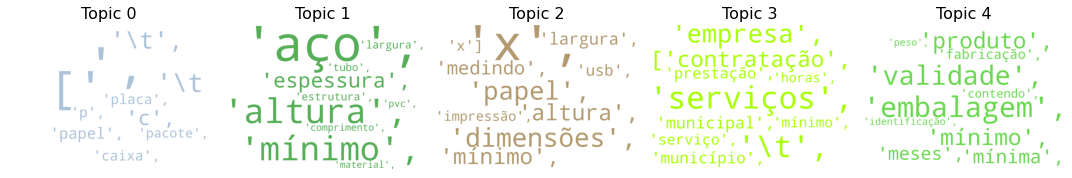

In [62]:
cols = [color for name, color in mcolors.XKCD_COLORS.items()]
cloud = WordCloud(stopwords=filter_out,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = nmf_model.show_topics(formatted=False)
fig, axes = plt.subplots(1, 5, figsize=(15,15), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=600)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### K-means + TfidfVectorizer

### Análise dos dados

### Conclusão

Counter Vectorizarion -> contar a ocorrência de cada palavra para mapear o texto para um número

CounterVectorizer

TfidfVectorizer -> cria a mais uma matriz de termos de documento a partir de nossas mensagens.
No entanto, em vez de preencher o DTM com contagens de token, ele calcula o valor da frequência do documento inverso da frequência do termo para cada palavra (TF-IDF).
Um fator de frequência de documento inverso é incorporado, o que diminui o peso dos termos que ocorrem com muita frequência no conjunto de documentos e aumenta o peso dos termos que ocorrem raramente.


Quais foram as áreas com maiores investimentos?

E quais foram os principais itens licitados nelas?